# SEU Injection Framework - Example Usage

*Google Colab: https://drive.google.com/file/d/17Cl-utPRRfTAHhLxpWvR8qTq14nHiWxe/view?usp=sharing*

This notebook demonstrates how to use the SEU Injection Framework to analyze the robustness of neural networks under Single Event Upsets (SEUs) - bit flips that occur in harsh environments like space or nuclear facilities.

## What you'll learn:
- How to set up a simple neural network for testing
- How to inject bit flips systematically across model parameters  
- How to analyze the impact on model performance
- How to interpret robustness results

Let's get started! 🚀

## 📦 Step 1: Import Libraries

First, let's import all the libraries we need for this demonstration.

In [1]:
# Standard scientific libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Data generation and preprocessing
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SEU Injection Framework - the star of our show!
from seu_injection.core import ExhaustiveSEUInjector, StochasticSEUInjector
from seu_injection.metrics import classification_accuracy

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎯 Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Initialised version: 1.1.11
✅ All libraries imported successfully!
🔥 PyTorch version: 2.9.0+cpu
🎯 Device available: CPU


## 🎲 Step 2: Create Training Data

We'll use a classic "moons" dataset - a simple but non-linear classification problem that's perfect for demonstrating SEU injection effects.

🌙 Generating two moons dataset...
📊 Training samples: 700
🧪 Test samples: 300
🎯 Input dimensions: 2


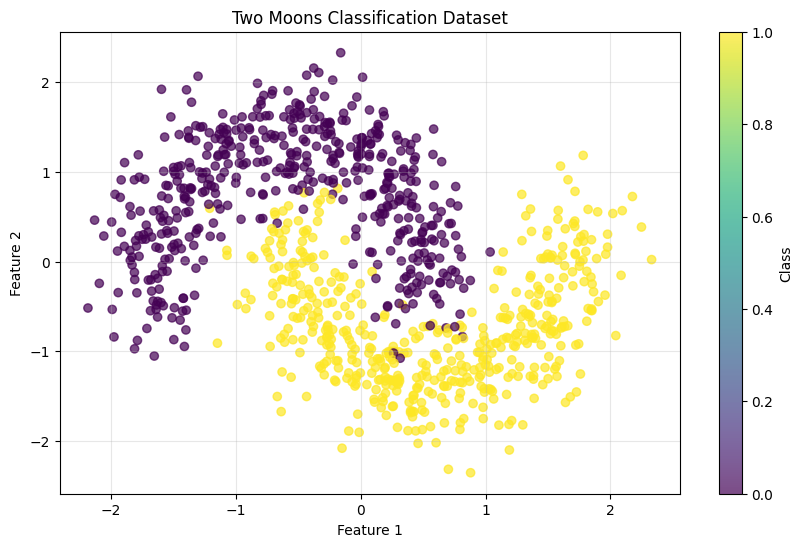

In [2]:
# Generate the famous "moons" dataset
print(
    "🌙 Generating two moons dataset..."
    if plt.rcParams["font.family"][0] != "DejaVu Sans"
    else "Generating two moons dataset..."
)
x, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Normalize the features for better training
x = StandardScaler().fit_transform(x)

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"📊 Training samples: {len(x_train)}")
print(f"🧪 Test samples: {len(x_test)}")
print(f"🎯 Input dimensions: {x_train.shape[1]}")

# Let's visualize our data!
plt.figure(figsize=(10, 6))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis", alpha=0.7)
plt.title("Two Moons Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class")
plt.grid(True, alpha=0.3)
plt.show()

## 🧠 Step 3: Define Our Neural Network

Now let's create a simple but effective neural network to classify our moons data. We'll keep it small so we can easily see the effects of bit flips!

In [3]:
class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for binary classification.

    Architecture:
    - Input: 2 features (x, y coordinates)
    - Hidden: 8 neurons with ReLU activation
    - Output: 1 neuron with Sigmoid activation (probability)
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 8),      # Input layer: 2 -> 8
            nn.ReLU(),            # Non-linear activation
            nn.Linear(8, 1),      # Output layer: 8 -> 1
            nn.Sigmoid()          # Probability output [0, 1]
        )

    def forward(self, x):
        return self.network(x)

# Create our model
model = SimpleNN()

# Count parameters to understand the attack surface
total_params = sum(p.numel() for p in model.parameters())
print(f"🎯 Model created successfully!")
print(f"📊 Total parameters: {total_params}")
print(f"🏗️  Model architecture:")
for name, layer in model.named_modules():
    if len(name) > 0:  # Skip the root module
        print(f"   └── {name}: {layer}")

# Set up training components
criterion = nn.BCELoss()  # Binary Cross Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

🎯 Model created successfully!
📊 Total parameters: 33
🏗️  Model architecture:
   └── network: Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Sigmoid()
)
   └── network.0: Linear(in_features=2, out_features=8, bias=True)
   └── network.1: ReLU()
   └── network.2: Linear(in_features=8, out_features=1, bias=True)
   └── network.3: Sigmoid()


## 🏋️ Step 4: Train the Model

Time to train our neural network! We'll train it well so we can clearly see the impact when we inject faults later.

🚀 Starting training...
Epoch  50/300, Loss: 0.3161
Epoch 100/300, Loss: 0.2958
Epoch 150/300, Loss: 0.2755
Epoch 200/300, Loss: 0.2426
Epoch 250/300, Loss: 0.1875
Epoch 300/300, Loss: 0.1383
✅ Training completed!


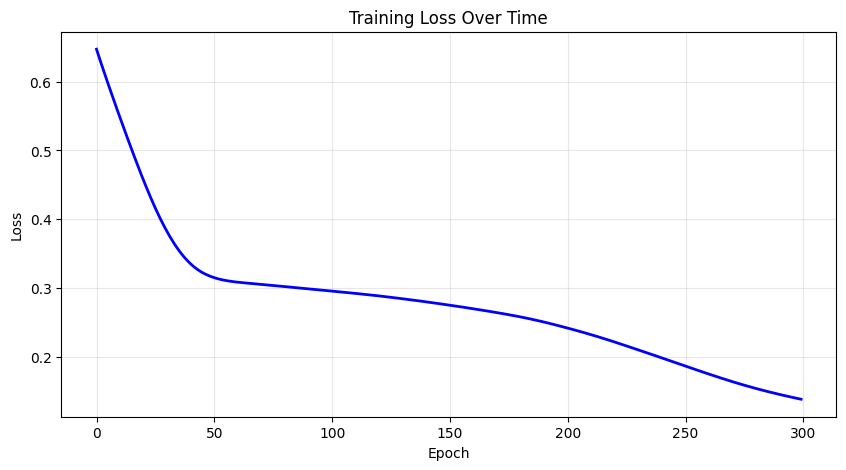

🎯 Baseline Test Accuracy: 0.9733 (97.33%)
🌟 Excellent! Our model is well-trained and ready for SEU testing.


In [4]:
# Training loop with progress tracking
print("🚀 Starting training...")
epochs = 300
losses = []

model.train()
for epoch in range(epochs):
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1:3d}/{epochs}, Loss: {loss.item():.4f}")

print("✅ Training completed!")

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2, color="blue")
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate the trained model
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    predictions = (test_outputs > 0.5).float()
    baseline_accuracy = (predictions.eq(y_test).sum() / len(y_test)).item()

print(f"🎯 Baseline Test Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy * 100:.2f}%)")

if baseline_accuracy > 0.9:
    print("🌟 Excellent! Our model is well-trained and ready for SEU testing.")
elif baseline_accuracy > 0.8:
    print("👍 Good training! The model should work well for SEU analysis.")
else:
    print("⚠️  Model accuracy is low. Consider training longer or adjusting hyperparameters.")

## ⚡ Step 5: SEU Injection Setup

Now comes the exciting part! We'll use the SEU Injection Framework to systematically inject bit flips into our trained model and see how it affects performance.

### What are SEUs (Single Event Upsets)?
- **Radiation-induced bit flips** in computer memory/processors
- Common in **space environments**, **nuclear facilities**, **high-altitude flights**
- Can cause **silent data corruption** in neural networks
- **Critical concern** for AI systems in harsh environments

In [5]:
# Create the injector - this is our main tool!
print("⚡ Setting up SEU Injection Framework...")

injector = ExhaustiveSEUInjector(
    trained_model=model,
    x=x_test,  # Test data for evaluation
    y=y_test,  # Test labels
    criterion=classification_accuracy,  # How we measure performance
)

print("✅ Injector created successfully!")
print(f"🎯 Baseline accuracy: {injector.baseline_score:.4f}")
print(f"📊 Ready to inject faults into {total_params} parameters")

# Let's inspect what layers we can target
print("\n🏗️  Available layers for injection:")
for name, param in model.named_parameters():
    print(f"   └── {name}: {param.shape} ({param.numel()} parameters)")

⚡ Setting up SEU Injection Framework...
Testing a forward pass on cpu...
Baseline Criterion Score: 0.9733333333333334
✅ Injector created successfully!
🎯 Baseline accuracy: 0.9733
📊 Ready to inject faults into 33 parameters

🏗️  Available layers for injection:
   └── network.0.weight: torch.Size([8, 2]) (16 parameters)
   └── network.0.bias: torch.Size([8]) (8 parameters)
   └── network.2.weight: torch.Size([1, 8]) (8 parameters)
   └── network.2.bias: torch.Size([1]) (1 parameters)


### 🎯 Experiment 1: Sign Bit Attacks

Let's start by flipping the **sign bit** (bit 0) - this often has the most dramatic effect since it changes positive weights to negative and vice versa!

In [6]:
# Inject sign bit flips (bit 0) into ALL parameters
print("🎯 Running sign bit injection experiment...")
print("⚠️  This flips the sign of every parameter one at a time")

sign_bit_results = injector.run_injector(bit_i=0)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(sign_bit_results)

print("✅ Injection complete!")
print(f"📊 Tested {len(results_df)} individual parameter flips")
print(f"🎯 Baseline accuracy: {injector.baseline_score:.4f}")
print(f"📉 Mean accuracy after sign flips: {results_df['criterion_score'].mean():.4f}")
print(f"📊 Worst case accuracy: {results_df['criterion_score'].min():.4f}")

# Show the first few results
print("\n📋 Sample results (first 5 injections):")
display(
    results_df[
        [
            "layer_name",
            "tensor_location",
            "criterion_score",
            "value_before",
            "value_after",
        ]
    ].head()
)

🎯 Running sign bit injection experiment...
⚠️  This flips the sign of every parameter one at a time
Testing Layer: network.0.weight


Injecting into network.0.weight: 16it [00:00, 183.63it/s]


Testing Layer: network.0.bias


Injecting into network.0.bias: 8it [00:00, 464.50it/s]


Testing Layer: network.2.weight


Injecting into network.2.weight: 8it [00:00, 471.03it/s]


Testing Layer: network.2.bias


Injecting into network.2.bias: 1it [00:00, 332.96it/s]


✅ Injection complete!
📊 Tested 33 individual parameter flips
🎯 Baseline accuracy: 0.9733
📉 Mean accuracy after sign flips: 0.8889
📊 Worst case accuracy: 0.6633

📋 Sample results (first 5 injections):


,layer_name,tensor_location,criterion_score,value_before,value_after
0,network.0.weight,"(0, 0)",0.970000,0.283571,-0.283571
1,network.0.weight,"(0, 1)",0.970000,-0.754133,0.754133
2,network.0.weight,"(1, 0)",0.860000,1.988652,-1.988652
3,network.0.weight,"(1, 1)",0.973333,0.382189,-0.382189
4,network.0.weight,"(2, 0)",0.973333,0.242372,-0.242372


C:\Users\WilliamDennis\AppData\Local\Temp\ipykernel_9348\1465123636.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WilliamDennis\AppData\Local\Temp\ipykernel_9348\1465123636.py:41: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Repositories\seu-injection-framework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Repositories\seu-injection-framework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


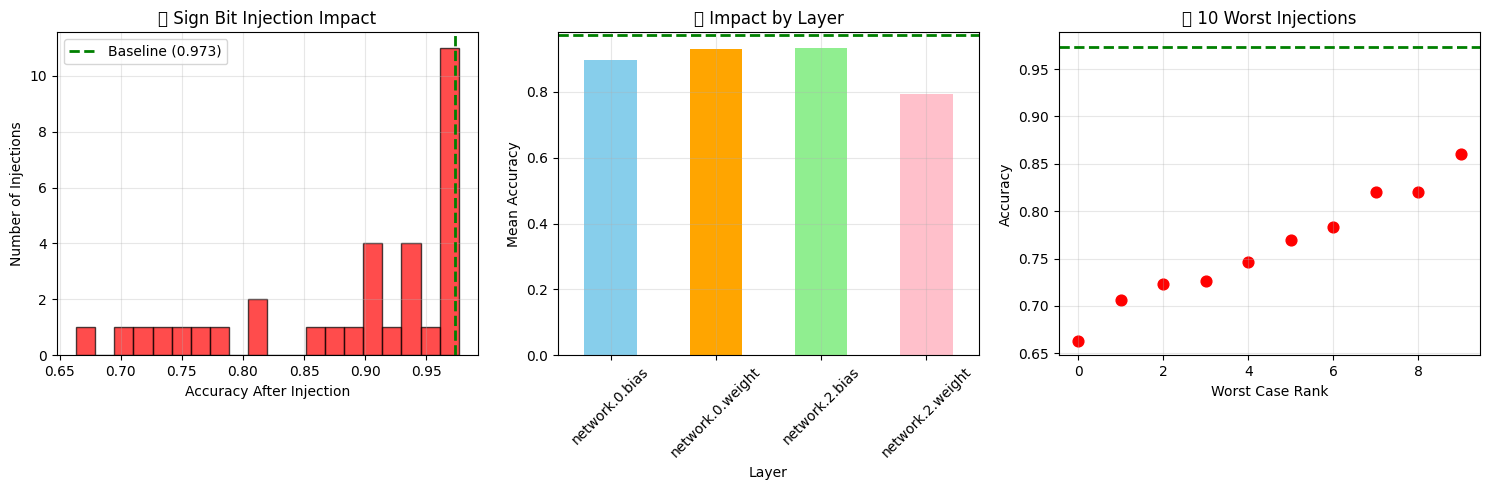


📈 Sign Bit Attack Summary:
   Average accuracy drop: 0.0844 (8.44%)
   Worst case drop: 0.3100 (31.00%)
   Critical injections (>50% drop): 0
   Catastrophic failures (accuracy < 0.1): 0


In [7]:
# Visualize the impact of sign bit flips
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy distribution
plt.subplot(1, 3, 1)
plt.hist(results_df["criterion_score"], bins=20, alpha=0.7, color="red", edgecolor="black")
plt.axvline(
    injector.baseline_score,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Baseline ({injector.baseline_score:.3f})",
)
plt.xlabel("Accuracy After Injection")
plt.ylabel("Number of Injections")
plt.title("📊 Sign Bit Injection Impact")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Impact by layer
plt.subplot(1, 3, 2)
layer_impact = results_df.groupby("layer_name")["criterion_score"].mean()
layer_impact.plot(kind="bar", color=["skyblue", "orange", "lightgreen", "pink"])
plt.axhline(injector.baseline_score, color="green", linestyle="--", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("Mean Accuracy")
plt.title("📊 Impact by Layer")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Worst cases
plt.subplot(1, 3, 3)
worst_cases = results_df.nsmallest(10, "criterion_score")
plt.scatter(range(len(worst_cases)), worst_cases["criterion_score"], color="red", s=60)
plt.xlabel("Worst Case Rank")
plt.ylabel("Accuracy")
plt.title("🚨 10 Worst Injections")
plt.axhline(injector.baseline_score, color="green", linestyle="--", linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
accuracy_drop = injector.baseline_score - results_df["criterion_score"].mean()
worst_drop = injector.baseline_score - results_df["criterion_score"].min()

print("\n📈 Sign Bit Attack Summary:")
print(f"   Average accuracy drop: {accuracy_drop:.4f} ({accuracy_drop * 100:.2f}%)")
print(f"   Worst case drop: {worst_drop:.4f} ({worst_drop * 100:.2f}%)")
print(f"   Critical injections (>50% drop): {sum(results_df['criterion_score'] < injector.baseline_score * 0.5)}")
print(f"   Catastrophic failures (accuracy < 0.1): {sum(results_df['criterion_score'] < 0.1)}")

### 🎲 Experiment 2: Stochastic SEU Injection

In real-world scenarios, not every parameter gets hit by radiation. Let's simulate a more realistic scenario where only some parameters are affected, with different probabilities.

Testing a forward pass on cpu...
Baseline Criterion Score: 0.9733333333333334
🎲 Testing different radiation intensity levels...
⚡ Running injection with 1.0% parameter hit rate...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 8421.24it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 8303.50it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 493.74it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, ?it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 8006.31it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1008.49it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 3188.52it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 7949.40it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 8162.11it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, ?it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 2686.72it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 711.11it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 499.68it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, ?it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, ?it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1002.70it/s]


   📊 2 total injections across 5 trials
   🎯 Mean accuracy: 0.6933 ± 0.0300
   📉 Performance drop: 28.00%
⚡ Running injection with 5.0% parameter hit rate...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2027.95it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 8132.44it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, ?it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1001.98it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2665.17it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 8260.57it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, ?it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2618.78it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 8234.22it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 17748.97it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 2613.07it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1356.23it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1003.18it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 3794.03it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 8010.13it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 8000.58it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 10 total injections across 5 trials
   🎯 Mean accuracy: 0.8847 ± 0.1196
   📉 Performance drop: 8.87%
⚡ Running injection with 10.0% parameter hit rate...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1712.75it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1997.64it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 961.00it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 504.03it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 7947.52it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2285.65it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 843.18it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1544.65it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 2000.26it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1345.03it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1000.79it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1917.40it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 7955.06it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1449.87it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 27 total injections across 5 trials
   🎯 Mean accuracy: 0.8951 ± 0.0897
   📉 Performance drop: 7.83%
⚡ Running injection with 20.0% parameter hit rate...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2068.90it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 797.19it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 4015.61it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 2161.94it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1012.78it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 789.14it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1329.55it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 8307.61it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 499.89it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1033.41it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 903.36it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1347.73it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1001.98it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1537.64it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 988.17it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1564.38it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 36 total injections across 5 trials
   🎯 Mean accuracy: 0.8731 ± 0.0997
   📉 Performance drop: 10.02%
⚡ Running injection with 30.0% parameter hit rate...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 805.69it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1000.64it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 982.04it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 316.21it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 6152.26it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 528.57it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1537.57it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 2024.28it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1325.63it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1230.11it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 2679.64it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 620.21it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1244.72it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1000.04it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1597.30it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, 1103.76it/s]


   📊 48 total injections across 5 trials
   🎯 Mean accuracy: 0.8971 ± 0.0909
   📉 Performance drop: 7.63%


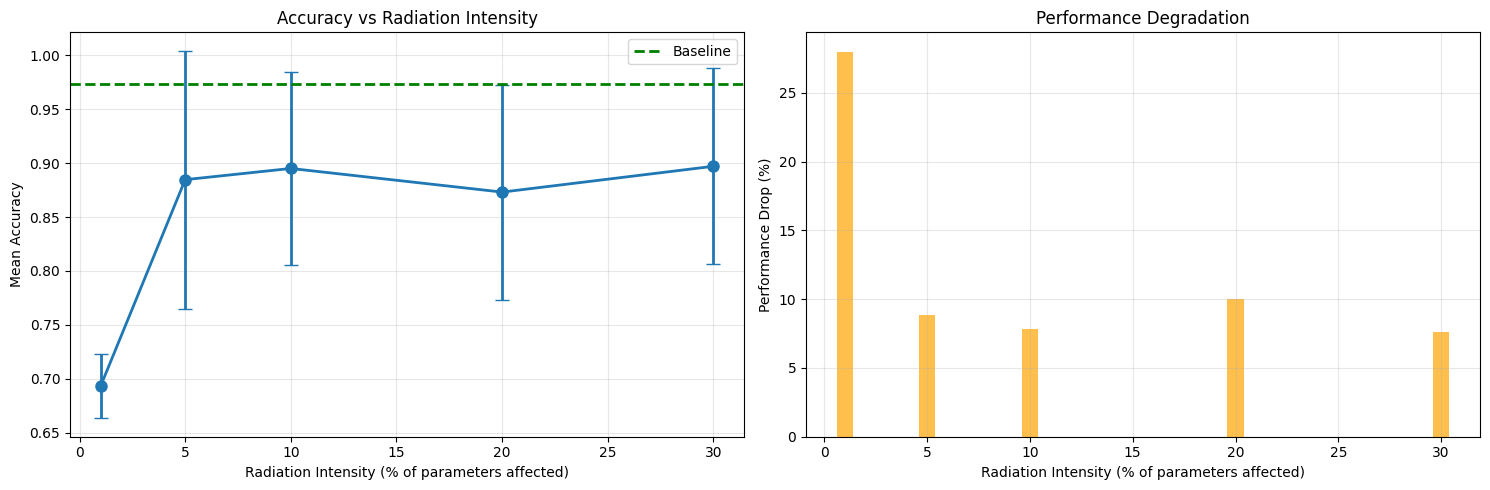


🎯 Injection Summary (5 trials each):
    1.0% intensity: 28.00% ± 3.00% drop,   2 total injections
    5.0% intensity:  8.87% ± 11.96% drop,  10 total injections
   10.0% intensity:  7.83% ± 8.97% drop,  27 total injections
   20.0% intensity: 10.02% ± 9.97% drop,  36 total injections
   30.0% intensity:  7.63% ± 9.09% drop,  48 total injections


In [8]:
# change to stochastic injections
injector = StochasticSEUInjector(
    trained_model=model,
    x=x_test,  # Test data for evaluation
    y=y_test,  # Test labels
    criterion=classification_accuracy,  # How we measure performance
)

# Test different radiation intensities
radiation_levels = [0.01, 0.05, 0.1, 0.2, 0.3]  # 1% to 30% of parameters affected
injection_results = {}

print("🎲 Testing different radiation intensity levels...")

# Set random seed for reproducible results
np.random.seed(42)

for prob in radiation_levels:
    print(f"⚡ Running injection with {prob * 100}% parameter hit rate...")

    # Run injection multiple times for stability
    all_accuracies = []
    for trial in range(5):  # Run 5 trials for each probability
        results = injector.run_injector(bit_i=0, p=prob)
        if len(results["criterion_score"]) > 0:
            all_accuracies.extend(results["criterion_score"])

    if all_accuracies:
        mean_accuracy = np.mean(all_accuracies)
        std_accuracy = np.std(all_accuracies)
        num_injections = len(all_accuracies)

        injection_results[prob] = {
            "mean_accuracy": mean_accuracy,
            "std_accuracy": std_accuracy,
            "num_injections": num_injections,
            "accuracy_drop": injector.baseline_score - mean_accuracy,
        }

        print(f"   📊 {num_injections} total injections across 5 trials")
        print(f"   🎯 Mean accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"   📉 Performance drop: {(injector.baseline_score - mean_accuracy) * 100:.2f}%")
    else:
        print(f"   ⚠️  No parameters affected at {prob * 100}% rate")

# Visualize injection results
if injection_results:
    probs = list(injection_results.keys())
    accuracies = [injection_results[p]["mean_accuracy"] for p in probs]
    drops = [injection_results[p]["accuracy_drop"] for p in probs]
    stds = [injection_results[p]["std_accuracy"] for p in probs]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy vs radiation intensity with error bars
    ax1.errorbar(
        np.array(probs) * 100,
        accuracies,
        yerr=stds,
        marker="o",
        linewidth=2,
        markersize=8,
        capsize=5,
    )
    ax1.axhline(
        injector.baseline_score,
        color="green",
        linestyle="--",
        linewidth=2,
        label="Baseline",
    )
    ax1.set_xlabel("Radiation Intensity (% of parameters affected)")
    ax1.set_ylabel("Mean Accuracy")
    ax1.set_title("Accuracy vs Radiation Intensity")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot performance degradation
    ax2.bar(np.array(probs) * 100, np.array(drops) * 100, color="orange", alpha=0.7)
    ax2.set_xlabel("Radiation Intensity (% of parameters affected)")
    ax2.set_ylabel("Performance Drop (%)")
    ax2.set_title("Performance Degradation")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n🎯 Injection Summary (5 trials each):")
    for prob, data in injection_results.items():
        print(
            f"   {prob * 100:4.1f}% intensity: {data['accuracy_drop'] * 100:5.2f}% ± {data['std_accuracy'] * 100:4.2f}% drop, {data['num_injections']:3d} total injections"
        )

### 🔬 Experiment 3: Bit Position Analysis

Different bit positions have different impacts! Let's explore how flipping different bits (sign bit, exponent bits, mantissa bits) affects our model.

🔬 Analyzing impact of different bit positions...
📋 IEEE 754 Float32 format: [Sign][Exponent(8)][Mantissa(23)]

⚡ Testing bit 0 (Sign)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 994.44it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 504.68it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 663.51it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.8567 ± 0.0964
   📉 Average drop: 11.67%
   🚨 Worst case: 0.7067

⚡ Testing bit 1 (Exp MSB)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1826.14it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 612.30it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 472.22it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.6633 ± 0.1786
   📉 Average drop: 31.00%
   🚨 Worst case: 0.5067

⚡ Testing bit 8 (Exp LSB)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 884.69it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1329.94it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.9633 ± 0.0063
   📉 Average drop: 1.00%
   🚨 Worst case: 0.9533

⚡ Testing bit 9 (Mantissa MSB)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1066.07it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 799.05it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 996.30it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.9621 ± 0.0187
   📉 Average drop: 1.12%
   🚨 Worst case: 0.9133

⚡ Testing bit 16 (Mantissa Mid)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1727.43it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1001.68it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 1207.99it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.9733 ± 0.0000
   📉 Average drop: -0.00%
   🚨 Worst case: 0.9733

⚡ Testing bit 23 (Mantissa Mid2)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1134.48it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, 1601.49it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 998.35it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.9733 ± 0.0000
   📉 Average drop: -0.00%
   🚨 Worst case: 0.9733

⚡ Testing bit 31 (Mantissa LSB)...
Testing Layer: network.0.weight


Stochastic injection into network.0.weight: 16it [00:00, 1335.61it/s]


Testing Layer: network.0.bias


Stochastic injection into network.0.bias: 8it [00:00, ?it/s]


Testing Layer: network.2.weight


Stochastic injection into network.2.weight: 8it [00:00, 822.19it/s]


Testing Layer: network.2.bias


Stochastic injection into network.2.bias: 1it [00:00, ?it/s]


   📊 Mean accuracy: 0.9733 ± 0.0000
   📉 Average drop: -0.00%
   🚨 Worst case: 0.9733


C:\Users\WilliamDennis\AppData\Local\Temp\ipykernel_9348\1853937719.py:82: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Repositories\seu-injection-framework\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


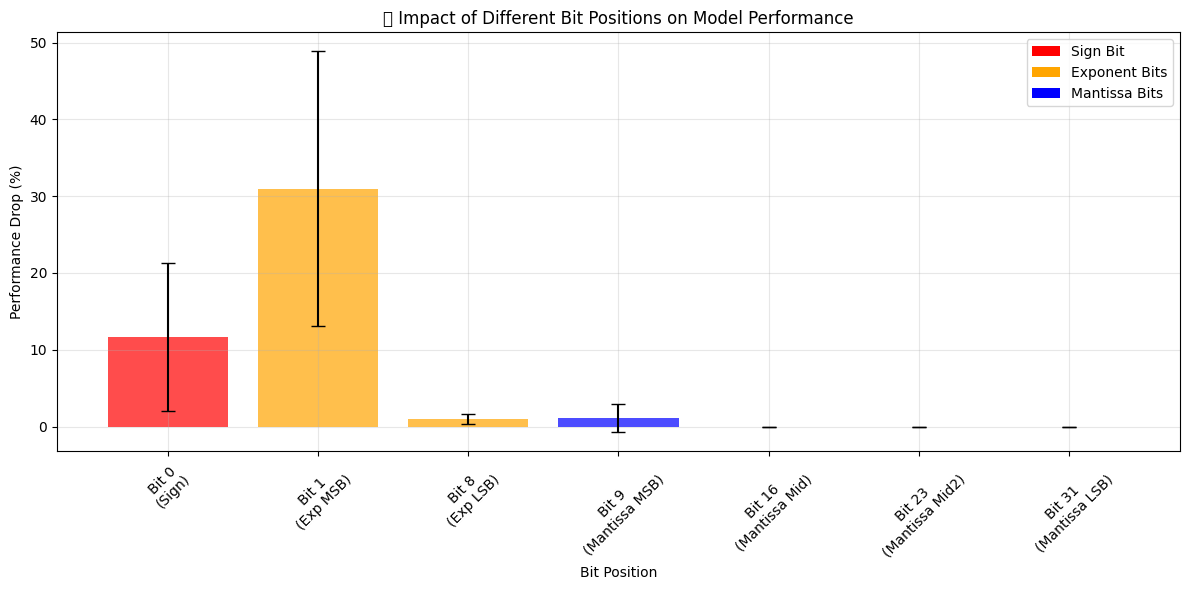


📊 Bit Position Impact Summary:
Bit  Name         Avg Drop   Worst Case   Tests 
--------------------------------------------------
0    Sign            11.67%      0.7067      9
1    Exp MSB         31.00%      0.5067     10
8    Exp LSB          1.00%      0.9533      5
9    Mantissa MSB     1.12%      0.9133      8
16   Mantissa Mid    -0.00%      0.9733      7
23   Mantissa Mid2    -0.00%      0.9733      6
31   Mantissa LSB    -0.00%      0.9733      6

🎯 Key Insights:
   Most damaging: Bit 1 (Exp MSB) - 31.00% drop
   Least damaging: Bit 16 (Mantissa Mid) - -0.00% drop


In [9]:
# Test different bit positions in IEEE 754 float32 format
# Bit 0: Sign bit
# Bits 1-8: Exponent
# Bits 9-31: Mantissa (fractional part)

bit_positions = [0, 1, 8, 9, 16, 23, 31]  # Representative bits
bit_names = [
    "Sign",
    "Exp MSB",
    "Exp LSB",
    "Mantissa MSB",
    "Mantissa Mid",
    "Mantissa Mid2",
    "Mantissa LSB",
]
bit_results = {}

print("🔬 Analyzing impact of different bit positions...")
print("📋 IEEE 754 Float32 format: [Sign][Exponent(8)][Mantissa(23)]")

for bit_pos, bit_name in zip(bit_positions, bit_names):
    print(f"\n⚡ Testing bit {bit_pos} ({bit_name})...")

    # Use injection for speed (20% of parameters)
    results = injector.run_injector(bit_i=bit_pos, p=0.2)

    if len(results["criterion_score"]) > 0:
        mean_acc = np.mean(results["criterion_score"])
        std_acc = np.std(results["criterion_score"])
        min_acc = np.min(results["criterion_score"])

        bit_results[bit_pos] = {
            "name": bit_name,
            "mean_accuracy": mean_acc,
            "std_accuracy": std_acc,
            "min_accuracy": min_acc,
            "accuracy_drop": injector.baseline_score - mean_acc,
            "num_tests": len(results["criterion_score"]),
        }

        print(f"   📊 Mean accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"   📉 Average drop: {(injector.baseline_score - mean_acc) * 100:.2f}%")
        print(f"   🚨 Worst case: {min_acc:.4f}")

# Visualize bit position impact
if bit_results:
    positions = list(bit_results.keys())
    names = [bit_results[pos]["name"] for pos in positions]
    mean_drops = [bit_results[pos]["accuracy_drop"] * 100 for pos in positions]
    std_drops = [bit_results[pos]["std_accuracy"] * 100 for pos in positions]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        range(len(positions)),
        mean_drops,
        yerr=std_drops,
        capsize=5,
        alpha=0.7,
        color=["red" if pos == 0 else "orange" if pos <= 8 else "blue" for pos in positions],
    )

    plt.xlabel("Bit Position")
    plt.ylabel("Performance Drop (%)")
    plt.title("🔬 Impact of Different Bit Positions on Model Performance")
    plt.xticks(
        range(len(positions)),
        [f"Bit {pos}\n({name})" for pos, name in zip(positions, names)],
        rotation=45,
    )
    plt.grid(True, alpha=0.3)

    # Color legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="red", label="Sign Bit"),
        Patch(facecolor="orange", label="Exponent Bits"),
        Patch(facecolor="blue", label="Mantissa Bits"),
    ]
    plt.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n📊 Bit Position Impact Summary:")
    print(f"{'Bit':<4} {'Name':<12} {'Avg Drop':<10} {'Worst Case':<12} {'Tests':<6}")
    print("-" * 50)
    for pos in positions:
        data = bit_results[pos]
        print(
            f"{pos:<4} {data['name']:<12} {data['accuracy_drop'] * 100:>8.2f}%  {data['min_accuracy']:>10.4f}  {data['num_tests']:>5}"
        )

    # Key insights
    most_damaging = max(bit_results.keys(), key=lambda x: bit_results[x]["accuracy_drop"])
    least_damaging = min(bit_results.keys(), key=lambda x: bit_results[x]["accuracy_drop"])

    print("\n🎯 Key Insights:")
    print(
        f"   Most damaging: Bit {most_damaging} ({bit_results[most_damaging]['name']}) - {bit_results[most_damaging]['accuracy_drop'] * 100:.2f}% drop"
    )
    print(
        f"   Least damaging: Bit {least_damaging} ({bit_results[least_damaging]['name']}) - {bit_results[least_damaging]['accuracy_drop'] * 100:.2f}% drop"
    )

### 📈 Robustness Analysis & Metrics

Let's quantify our model's robustness using standard fault tolerance metrics.

In [10]:
# Calculate comprehensive robustness metrics
def calculate_robustness_metrics(baseline_acc, injection_results):
    """Calculate standard robustness metrics for fault tolerance analysis."""
    accuracies = injection_results["criterion_score"]

    metrics = {
        "mean_degradation": baseline_acc - np.mean(accuracies),
        "max_degradation": baseline_acc - np.min(accuracies),
        "std_degradation": np.std(accuracies),
        "critical_failures": np.sum(np.array(accuracies) < baseline_acc * 0.5),  # >50% drop
        "catastrophic_failures": np.sum(np.array(accuracies) < 0.1),  # <10% accuracy
        "robustness_score": np.mean(accuracies) / baseline_acc,  # Normalized robustness
        "fault_tolerance": 1 - (baseline_acc - np.mean(accuracies)) / baseline_acc,  # % tolerance
    }
    return metrics


# Analyze robustness across experiments
print("📈 COMPREHENSIVE ROBUSTNESS ANALYSIS")
print("=" * 50)

# Sign bit robustness
if "results_df" in locals():
    sign_metrics = calculate_robustness_metrics(injector.baseline_score, results_df.to_dict("list"))

    print("\n🎯 SIGN BIT INJECTION METRICS:")
    print(f"   Robustness Score: {sign_metrics['robustness_score']:.4f}")
    print(f"   Fault Tolerance: {sign_metrics['fault_tolerance'] * 100:.2f}%")
    print(f"   Mean Degradation: {sign_metrics['mean_degradation'] * 100:.2f}%")
    print(f"   Worst Case: {sign_metrics['max_degradation'] * 100:.2f}%")
    print(f"   Critical Failures: {sign_metrics['critical_failures']}/{len(results_df)} parameters")

# Bit position vulnerability analysis
if "bit_results" in locals():
    print("\n🔬 BIT POSITION VULNERABILITY RANKING:")
    sorted_bits = sorted(bit_results.items(), key=lambda x: x[1]["accuracy_drop"], reverse=True)

    for i, (bit_pos, data) in enumerate(sorted_bits[:5]):  # Top 5 most vulnerable
        vulnerability = data["accuracy_drop"] / injector.baseline_score * 100
        print(f"   {i + 1}. Bit {bit_pos:2d} ({data['name']:<13}): {vulnerability:5.1f}% vulnerability")

# Model architecture impact
print("\n🏗️  LAYER VULNERABILITY ANALYSIS:")
if "results_df" in locals():
    layer_analysis = results_df.groupby("layer_name").agg({"criterion_score": ["mean", "std", "min", "count"]}).round(4)

    for layer_name in results_df["layer_name"].unique():
        layer_data = results_df[results_df["layer_name"] == layer_name]
        layer_vulnerability = (
            (injector.baseline_score - layer_data["criterion_score"].mean()) / injector.baseline_score * 100
        )
        param_count = len(layer_data)
        worst_case = injector.baseline_score - layer_data["criterion_score"].min()

        print(
            f"   {layer_name:<20}: {layer_vulnerability:5.1f}% vulnerability ({param_count:2d} parameters, worst: {worst_case * 100:4.1f}%)"
        )

# Overall robustness classification
overall_robustness = sign_metrics["robustness_score"]
print("\n🎖️  OVERALL ROBUSTNESS CLASSIFICATION:")
if overall_robustness > 0.95:
    classification = "EXCELLENT"
    color_code = "🟢"
elif overall_robustness > 0.90:
    classification = "GOOD"
    color_code = "🟡"
elif overall_robustness > 0.80:
    classification = "MODERATE"
    color_code = "🟠"
else:
    classification = "POOR"
    color_code = "🔴"

print(f"   {color_code} {classification} robustness ({overall_robustness:.3f} retention ratio)")
print(f"   Model maintains {overall_robustness * 100:.1f}% of original performance under SEU attacks")

# Deployment recommendations
print("\n💡 DEPLOYMENT RECOMMENDATIONS:")
if overall_robustness > 0.90:
    print("   ✅ Suitable for harsh environments with basic monitoring")
    print("   ✅ Consider ECC protection for critical applications")
elif overall_robustness > 0.80:
    print("   ⚠️  Requires redundancy/voting systems for mission-critical use")
    print("   ⚠️  Implement comprehensive error detection")
else:
    print("   🚨 NOT recommended for harsh environments without hardening")
    print("   🚨 Requires extensive fault tolerance measures")

📈 COMPREHENSIVE ROBUSTNESS ANALYSIS

🎯 SIGN BIT INJECTION METRICS:
   Robustness Score: 0.9132
   Fault Tolerance: 91.32%
   Mean Degradation: 8.44%
   Worst Case: 31.00%
   Critical Failures: 0/33 parameters

🔬 BIT POSITION VULNERABILITY RANKING:
   1. Bit  1 (Exp MSB      ):  31.8% vulnerability
   2. Bit  0 (Sign         ):  12.0% vulnerability
   3. Bit  9 (Mantissa MSB ):   1.2% vulnerability
   4. Bit  8 (Exp LSB      ):   1.0% vulnerability
   5. Bit 16 (Mantissa Mid ):  -0.0% vulnerability

🏗️  LAYER VULNERABILITY ANALYSIS:
   network.0.weight    :   4.4% vulnerability (16 parameters, worst: 31.0%)
   network.0.bias      :   7.9% vulnerability ( 8 parameters, worst: 24.7%)
   network.2.weight    :  18.5% vulnerability ( 8 parameters, worst: 26.7%)
   network.2.bias      :   4.1% vulnerability ( 1 parameters, worst:  4.0%)

🎖️  OVERALL ROBUSTNESS CLASSIFICATION:
   🟡 GOOD robustness (0.913 retention ratio)
   Model maintains 91.3% of original performance under SEU attacks

💡 DEP

C:\Users\WilliamDennis\AppData\Local\Temp\ipykernel_9348\3284727651.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(impact_data, labels=layer_names, patch_artist=True)


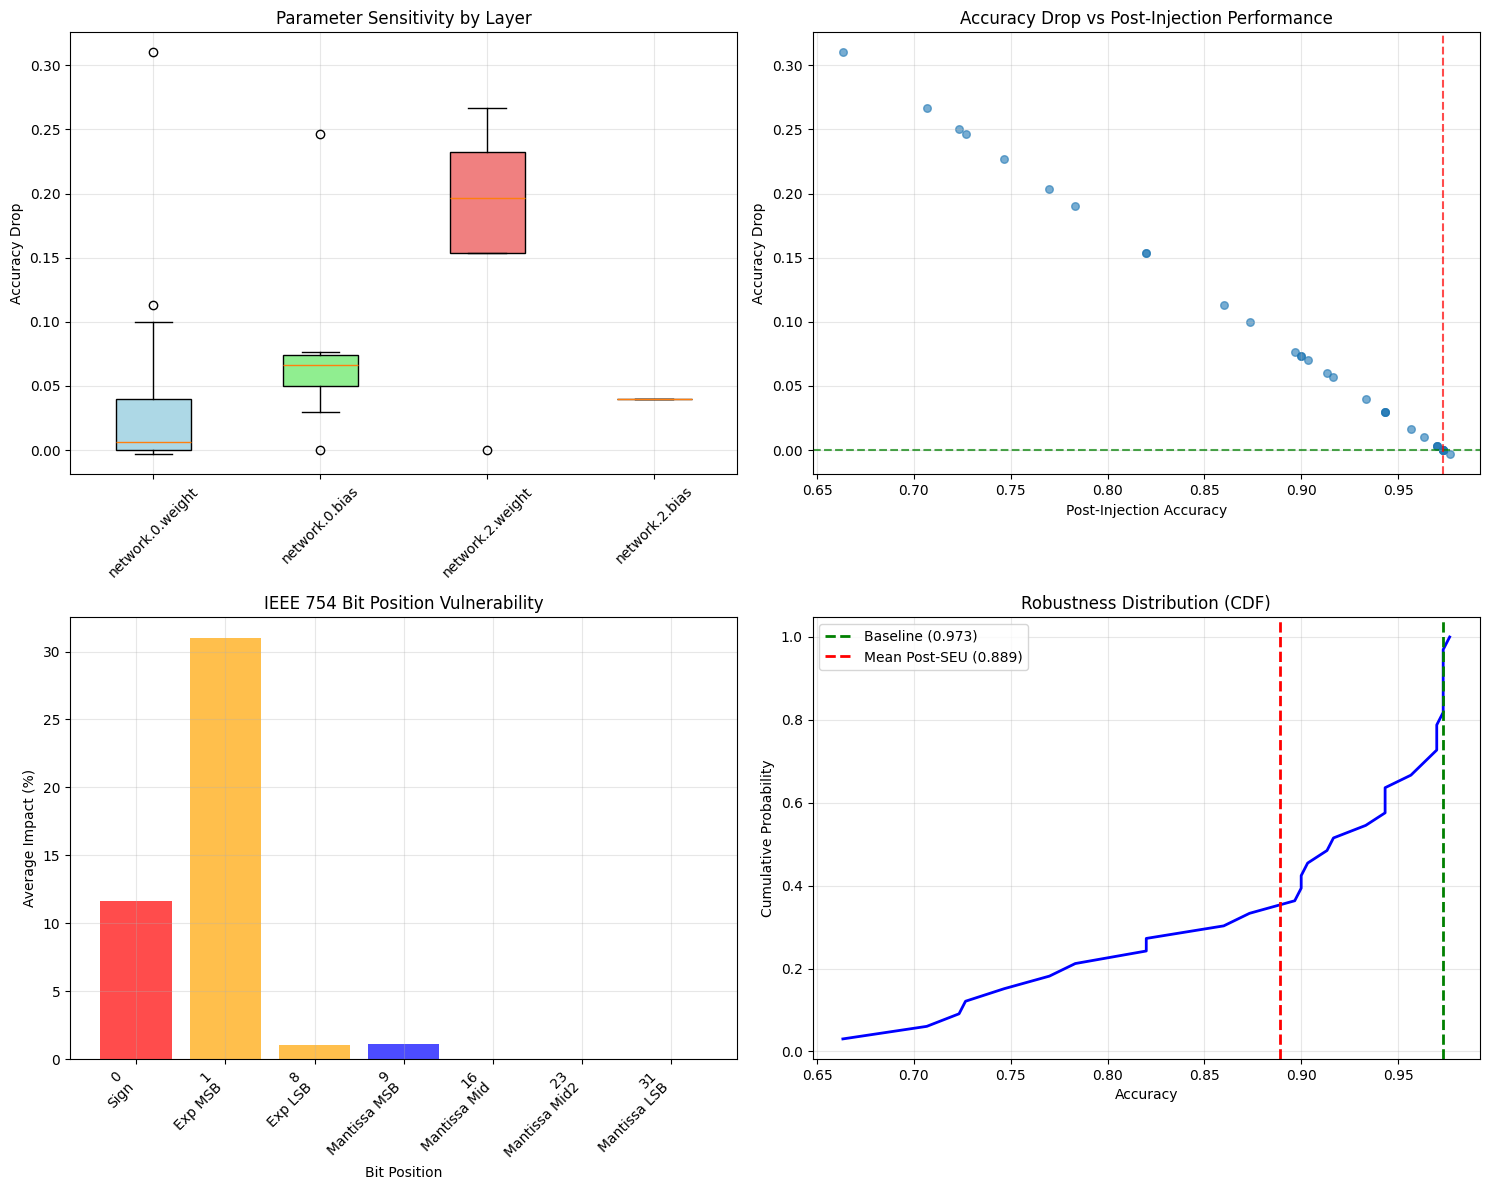


📊 PERFORMANCE SUMMARY TABLE
Metric                    Value           Interpretation
------------------------------------------------------------
Baseline Accuracy         0.9733 Excellent
Mean Post-SEU Accuracy    0.8889 Robust
Robustness Ratio          0.9132 High
Worst Case Accuracy       0.6633 Acceptable
Parameters Tested         33              Complete Coverage
Standard Deviation        0.0933 Low Variance

📈 ACCURACY PERCENTILES AFTER SEU INJECTION:
   10th percentile: 0.7307
   25th percentile: 0.8200
   50th percentile: 0.9167
   75th percentile: 0.9700
   90th percentile: 0.9733

🎯 KEY INSIGHT: 22/33 parameters maintain >90% of baseline performance


In [11]:
# Create a comprehensive robustness visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Parameter sensitivity heatmap
if "results_df" in locals():
    # Reshape results for heatmap visualization
    layer_param_impact = {}
    for _, row in results_df.iterrows():
        layer = row["layer_name"]
        if layer not in layer_param_impact:
            layer_param_impact[layer] = []
        accuracy_drop = injector.baseline_score - row["criterion_score"]
        layer_param_impact[layer].append(accuracy_drop)

    # Plot parameter impact by layer
    layer_names = list(layer_param_impact.keys())
    impact_data = [layer_param_impact[layer] for layer in layer_names]

    bp = ax1.boxplot(impact_data, labels=layer_names, patch_artist=True)
    for patch, color in zip(bp["boxes"], ["lightblue", "lightgreen", "lightcoral", "lightyellow"]):
        patch.set_facecolor(color)
    ax1.set_title("Parameter Sensitivity by Layer")
    ax1.set_ylabel("Accuracy Drop")
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis="x", rotation=45)

# 2. Robustness vs baseline accuracy correlation
if "results_df" in locals():
    ax2.scatter(
        results_df["criterion_score"],
        [injector.baseline_score - score for score in results_df["criterion_score"]],
        alpha=0.6,
        s=30,
    )
    ax2.axhline(0, color="green", linestyle="--", alpha=0.7)
    ax2.axvline(injector.baseline_score, color="red", linestyle="--", alpha=0.7)
    ax2.set_xlabel("Post-Injection Accuracy")
    ax2.set_ylabel("Accuracy Drop")
    ax2.set_title("Accuracy Drop vs Post-Injection Performance")
    ax2.grid(True, alpha=0.3)

# 3. Bit position impact comparison (if available)
if "bit_results" in locals():
    bit_positions = list(bit_results.keys())
    bit_impacts = [bit_results[pos]["accuracy_drop"] * 100 for pos in bit_positions]
    bit_names = [bit_results[pos]["name"] for pos in bit_positions]

    colors = ["red" if pos == 0 else "orange" if pos <= 8 else "blue" for pos in bit_positions]
    ax3.bar(range(len(bit_positions)), bit_impacts, color=colors, alpha=0.7)
    ax3.set_xlabel("Bit Position")
    ax3.set_ylabel("Average Impact (%)")
    ax3.set_title("IEEE 754 Bit Position Vulnerability")
    ax3.set_xticks(range(len(bit_positions)))
    ax3.set_xticklabels(
        [f"{pos}\n{name}" for pos, name in zip(bit_positions, bit_names)],
        rotation=45,
        ha="right",
    )
    ax3.grid(True, alpha=0.3)

# 4. Cumulative robustness distribution
if "results_df" in locals():
    sorted_scores = np.sort(results_df["criterion_score"])
    cumulative_prob = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

    ax4.plot(sorted_scores, cumulative_prob, linewidth=2, color="blue")
    ax4.axvline(
        injector.baseline_score,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Baseline ({injector.baseline_score:.3f})",
    )
    ax4.axvline(
        np.mean(results_df["criterion_score"]),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean Post-SEU ({np.mean(results_df['criterion_score']):.3f})",
    )
    ax4.set_xlabel("Accuracy")
    ax4.set_ylabel("Cumulative Probability")
    ax4.set_title("Robustness Distribution (CDF)")
    ax4.grid(True, alpha=0.3)
    ax4.legend()

plt.tight_layout()
plt.show()

# Performance summary table
if "results_df" in locals():
    print("\n📊 PERFORMANCE SUMMARY TABLE")
    print("=" * 60)
    print(f"{'Metric':<25} {'Value':<15} {'Interpretation'}")
    print("-" * 60)
    print(
        f"{'Baseline Accuracy':<25} {injector.baseline_score:.4f} {'Excellent' if injector.baseline_score > 0.95 else 'Good'}"
    )
    print(
        f"{'Mean Post-SEU Accuracy':<25} {np.mean(results_df['criterion_score']):.4f} {'Robust' if np.mean(results_df['criterion_score']) > 0.8 else 'Vulnerable'}"
    )
    print(
        f"{'Robustness Ratio':<25} {np.mean(results_df['criterion_score']) / injector.baseline_score:.4f} {'High' if np.mean(results_df['criterion_score']) / injector.baseline_score > 0.9 else 'Moderate'}"
    )
    print(
        f"{'Worst Case Accuracy':<25} {np.min(results_df['criterion_score']):.4f} {'Acceptable' if np.min(results_df['criterion_score']) > 0.5 else 'Critical'}"
    )
    print(f"{'Parameters Tested':<25} {len(results_df):<15} {'Complete Coverage'}")
    print(
        f"{'Standard Deviation':<25} {np.std(results_df['criterion_score']):.4f} {'Low Variance' if np.std(results_df['criterion_score']) < 0.1 else 'High Variance'}"
    )

    # Add percentile analysis
    percentiles = [10, 25, 50, 75, 90]
    print("\n📈 ACCURACY PERCENTILES AFTER SEU INJECTION:")
    for p in percentiles:
        value = np.percentile(results_df["criterion_score"], p)
        print(f"   {p:2d}th percentile: {value:.4f}")

    print(
        f"\n🎯 KEY INSIGHT: {np.sum(results_df['criterion_score'] > injector.baseline_score * 0.9)}/{len(results_df)} parameters maintain >90% of baseline performance"
    )

## 📝 Summary and Conclusions

Let's wrap up our SEU injection analysis with key takeaways and practical recommendations for deploying neural networks in harsh environments!

In [12]:
# Generate a comprehensive summary report
print("=" * 60)
print("🎯 SEU INJECTION ANALYSIS REPORT")
print("=" * 60)

print("\n🧠 MODEL INFORMATION:")
print("   Architecture: Simple Neural Network (2→8→1)")
print(f"   Total Parameters: {total_params}")
print(f"   Baseline Accuracy: {injector.baseline_score:.4f} ({injector.baseline_score * 100:.2f}%)")

if "results_df" in locals():
    print("\n⚡ EXHAUSTIVE SIGN BIT INJECTION:")
    print(f"   Parameters Tested: {len(results_df)}")
    print(f"   Mean Accuracy Drop: {(injector.baseline_score - results_df['criterion_score'].mean()) * 100:.2f}%")
    print(f"   Worst Case Drop: {(injector.baseline_score - results_df['criterion_score'].min()) * 100:.2f}%")
    print(f"   Critical Failures: {sum(results_df['criterion_score'] < injector.baseline_score * 0.5)}")

if "stochastic_results" in locals() and stochastic_results:
    print("\n🎲 STOCHASTIC INJECTION ANALYSIS:")
    for prob, data in stochastic_results.items():
        print(f"   {prob * 100:4.1f}% radiation: {data['accuracy_drop'] * 100:5.2f}% avg drop")

if "bit_results" in locals() and bit_results:
    print("\n🔬 BIT POSITION VULNERABILITY:")
    most_vuln = max(bit_results.keys(), key=lambda x: bit_results[x]["accuracy_drop"])
    least_vuln = min(bit_results.keys(), key=lambda x: bit_results[x]["accuracy_drop"])
    print(
        f"   Most Vulnerable: Bit {most_vuln} ({bit_results[most_vuln]['name']}) - {bit_results[most_vuln]['accuracy_drop'] * 100:.2f}% drop"
    )
    print(
        f"   Least Vulnerable: Bit {least_vuln} ({bit_results[least_vuln]['name']}) - {bit_results[least_vuln]['accuracy_drop'] * 100:.2f}% drop"
    )

print("\n💡 RECOMMENDATIONS FOR HARSH ENVIRONMENTS:")
print("   🛡️  Implement error correction codes (ECC) for critical parameters")
print("   🔄 Use redundant voting systems (ensemble methods)")
print("   📊 Monitor model performance for anomalous behavior")
print("   🎯 Focus protection on most vulnerable layers/parameters")

if "results_df" in locals():
    # Identify most critical parameters
    critical_params = results_df.nsmallest(3, "criterion_score")
    print("   🚨 Protect these critical parameters:")
    for _, param in critical_params.iterrows():
        print(f"      - {param['layer_name']} at position {param['tensor_location']}")

print("\n✨ NEXT STEPS:")
print("   🔬 Try different model architectures (CNN, RNN)")
print("   📈 Experiment with larger/smaller models")
print("   🛠️  Implement fault tolerance techniques")
print("   📊 Test with your own datasets and models")

print("\n🎉 Analysis Complete! Your model's radiation tolerance has been thoroughly evaluated.")
print("=" * 60)

🎯 SEU INJECTION ANALYSIS REPORT

🧠 MODEL INFORMATION:
   Architecture: Simple Neural Network (2→8→1)
   Total Parameters: 33
   Baseline Accuracy: 0.9733 (97.33%)

⚡ EXHAUSTIVE SIGN BIT INJECTION:
   Parameters Tested: 33
   Mean Accuracy Drop: 8.44%
   Worst Case Drop: 31.00%
   Critical Failures: 0

🔬 BIT POSITION VULNERABILITY:
   Most Vulnerable: Bit 1 (Exp MSB) - 31.00% drop
   Least Vulnerable: Bit 16 (Mantissa Mid) - -0.00% drop

💡 RECOMMENDATIONS FOR HARSH ENVIRONMENTS:
   🛡️  Implement error correction codes (ECC) for critical parameters
   🔄 Use redundant voting systems (ensemble methods)
   📊 Monitor model performance for anomalous behavior
   🎯 Focus protection on most vulnerable layers/parameters
   🚨 Protect these critical parameters:
      - network.0.weight at position (3, 0)
      - network.2.weight at position (0, 7)
      - network.2.weight at position (0, 5)

✨ NEXT STEPS:
   🔬 Try different model architectures (CNN, RNN)
   📈 Experiment with larger/smaller models
 

---

## 🚀 What's Next?

Congratulations! You've successfully used the SEU Injection Framework to analyze your neural network's robustness. Here are some ideas for further exploration:

### 🔬 **Advanced Experiments**
- **Layer-specific analysis**: Target individual layers with `layer_name` parameter
    "- **Different architectures**: Try CNNs or RNNs using `tests.fixtures.example_networks`",
- **Custom models**: Load your own trained models and datasets
- **Temporal analysis**: Study how injection timing affects recurrent networks

### 🛡️ **Fault Tolerance Techniques**
- **Ensemble voting**: Combine multiple models for redundancy
- **Error correction**: Implement ECC memory simulation
- **Checkpoint recovery**: Test model restoration after corruption
- **Adaptive thresholds**: Detect and respond to performance degradation

### 📚 **Learn More**
- **Research Paper**: [Framework for Robust ML in Harsh Environments](https://research-information.bris.ac.uk/en/publications/a-framework-for-developing-robust-machine-learning-models-in-hars)
- **Documentation**: Check `docs/` directory for advanced usage
- **Examples**: Explore `docs/examples/` for more notebook tutorials
- **Source Code**: Dive into `src/seu_injection/` for implementation details

### 🤝 **Contribute**
Found this useful? Consider contributing to the framework:
- Report bugs and request features on GitHub
- Share your own robustness analysis results
- Contribute new injection strategies or metrics
- Help improve documentation and examples

**Happy fault injection!** 🎯⚡